# Training a new tokenizer from old one.

If a language is trained on a different corpus then you need to train a new tokenizer from scratch for the new corpus.

Transformer Models use *subword tokenization algorithm* which splits words into subwords which are occuring most frequently in the corpus. For that the tokenizer algorithm need to take a hard look at the samples (training).

Training a tokenizer is different from training a model , model uses SGD to update params and it is stohastic. While training tokenizer estimates the fequent words using statistical models which is always deterministic in nature. We'll get the same result on repeated re-run.

We use the `AutoTokenizer.train_new_from_iterator()` for that.

**Getting new corpus**

In [ ]:
# !pip install datasets

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("code_search_net", "python")
print("dataset info: \n" , raw_datasets["train"])

print(raw_datasets["train"][123456]["whole_func_string"])

dataset info: 
 Dataset({
    features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url'],
    num_rows: 412178
})
def core_properties(self):
        """
        Instance of |CoreProperties| holding the read/write Dublin Core
        document properties for this presentation. Creates a default core
        properties part if one is not present (not common).
        """
        try:
            return self.part_related_by(RT.CORE_PROPERTIES)
        except KeyError:
            core_props = CorePropertiesPart.default()
            self.relate_to(core_props, RT.CORE_PROPERTIES)
            return core_props


There is both code and its description in docstring, hence we need to tokenize both in the dataset and the tokenizer need to be trained for both also.

First we need to transform the dataset into a interator of list of texts, which is ( a list of list of texts ). Using lists of texts will enable our tokenizer to go faster (training on batches of texts instead of processing individual texts one by one). Using a Python generator, we can avoid Python loading anything into memory until it's actually necessary 🤗 Datasets does not load everything into RAM but stores the elements of the dataset on disk.

The below line does not fetch any results as it is an generator object. The purpose of that is to avoid loading the whole data in the memory and instead laod when it is absolutely needed.

In [ ]:
def get_training_corpus():
    return (
        raw_datasets["train"][i : i + 1000]["whole_func_string"]
        for i in range(0, len(raw_datasets["train"]), 1000))


training_corpus = get_training_corpus()

**Training a new tokenizer**

We don't need to train a tokenizer entirely from scratch instead we can load an existing tokenizer and train from that checkpoint. This way we don't need to specify the special tokens we want to ue.  We aim to just add new things to the existing vocabulary instead of creating one from scratch itself.

- Note that `AutoTokenizer.train_new_from_iterator()` only works if the tokenizer you are using is a “fast” tokenizer


In [ ]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2", device = "auto")

example = '''def add_numbers(a, b):
    """Add the two numbers `a` and `b`."""
    return a + b'''

tokens = old_tokenizer.tokenize(example)
tokens

['def',
 'Ġadd',
 '_',
 'n',
 'umbers',
 '(',
 'a',
 ',',
 'Ġb',
 '):',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġ"""',
 'Add',
 'Ġthe',
 'Ġtwo',
 'Ġnumbers',
 'Ġ`',
 'a',
 '`',
 'Ġand',
 'Ġ`',
 'b',
 '`',
 '."',
 '""',
 'Ċ',
 'Ġ',
 'Ġ',
 'Ġ',
 'Ġreturn',
 'Ġa',
 'Ġ+',
 'Ġb']

As you can see there is a lot if spaces and newline tokens , this is a problem as the code has a lot of intentations would result in a lot of tokens like that  like Ġ and Ċ.

Here we again see the special symbols Ġ and Ċ that denote spaces and newlines, but we can also see that our tokenizer learned some tokens that are highly specific to a corpus of Python functions like the token `'def'`.

In [ ]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

In [ ]:
example = """class LinearLayer():
    def __init__(self, input_size, output_size):
        self.weight = torch.randn(input_size, output_size)
        self.bias = torch.zeros(output_size)

    def __call__(self, x):
        return x @ self.weights + self.bias
    """

tokens = tokenizer.tokenize(example)
print("The new tokens \n:", tokens)

tokenizer.save_pretrained("code-search-net-tokenizer")

The new tokens 
: ['class', 'ĠLinear', 'Layer', '():', 'ĊĠĠĠ', 'Ġdef', 'Ġ__', 'init', '__(', 'self', ',', 'Ġinput', '_', 'size', ',', 'Ġoutput', '_', 'size', '):', 'ĊĠĠĠĠĠĠĠ', 'Ġself', '.', 'weight', 'Ġ=', 'Ġtorch', '.', 'randn', '(', 'input', '_', 'size', ',', 'Ġoutput', '_', 'size', ')', 'ĊĠĠĠĠĠĠĠ', 'Ġself', '.', 'bias', 'Ġ=', 'Ġtorch', '.', 'zeros', '(', 'output', '_', 'size', ')', 'ĊĊĠĠĠ', 'Ġdef', 'Ġ__', 'call', '__(', 'self', ',', 'Ġx', '):', 'ĊĠĠĠĠĠĠĠ', 'Ġreturn', 'Ġx', 'Ġ@', 'Ġself', '.', 'weights', 'Ġ+', 'Ġself', '.', 'bias', 'ĊĠĠĠĠ']


('code-search-net-tokenizer/tokenizer_config.json',
 'code-search-net-tokenizer/special_tokens_map.json',
 'code-search-net-tokenizer/vocab.json',
 'code-search-net-tokenizer/merges.txt',
 'code-search-net-tokenizer/added_tokens.json',
 'code-search-net-tokenizer/tokenizer.json')

In [ ]:
tokens

['class',
 'ĠLinear',
 'Layer',
 '():',
 'ĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'init',
 '__(',
 'self',
 ',',
 'Ġinput',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'weight',
 'Ġ=',
 'Ġtorch',
 '.',
 'randn',
 '(',
 'input',
 '_',
 'size',
 ',',
 'Ġoutput',
 '_',
 'size',
 ')',
 'ĊĠĠĠĠĠĠĠ',
 'Ġself',
 '.',
 'bias',
 'Ġ=',
 'Ġtorch',
 '.',
 'zeros',
 '(',
 'output',
 '_',
 'size',
 ')',
 'ĊĊĠĠĠ',
 'Ġdef',
 'Ġ__',
 'call',
 '__(',
 'self',
 ',',
 'Ġx',
 '):',
 'ĊĠĠĠĠĠĠĠ',
 'Ġreturn',
 'Ġx',
 'Ġ@',
 'Ġself',
 '.',
 'weights',
 'Ġ+',
 'Ġself',
 '.',
 'bias',
 'ĊĠĠĠĠ']

In addition to the token corresponding to an indentation, here we can also see a token for a double indentation: ĊĠĠĠĠĠĠĠ. The special Python words like class, init, call, self, and return are each tokenized as one token, and we can see that as well as splitting on _ and . the tokenizer correctly splits even camel-cased names: LinearLayer is tokenized as ["ĠLinear", "Layer"].

### Fast Tokenizers
Slow tokenizers are those written in Python inside the 🤗 Transformers library, while the fast versions are the ones provided by 🤗 Tokenizers, which are written in Rust. Tokenizer can do more than just enocode text into token ID and decode them back. To explore this more we try to reproduced **token-classification (NER)**  and even **question-answering** pipelines.

The output of a tokenizer is just not a python Dict, instead it is a special `BatchEncoding` object. Which supports parallelization. Fast Tokenizers are not just fats but they also comes with a feature called *offset mapping*.

- *offset mapping* means the tokenizer can always map the tokens to the original text it originated from and back (Mapping each word to the tokens it generated or mapping each character of the original text to the token it’s inside)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))
print()
print(tokenizer.is_fast)
print()
print("The tokens :", encoding.tokens())
print(encoding.word_ids())

<class 'transformers.tokenization_utils_base.BatchEncoding'>

True

The tokens : ['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in', 'Brooklyn', '.', '[SEP]']
[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]


# Inside the token-classification *pipeline*

First we get a base result from the pretrained pipeline. The aggrigation strategy used is `simple` it only does an average of the scores. There are other strategies like `max`, `average` and `first`.

Lastly, we can map any word or token to characters in the original text, and vice versa, via the `word_to_chars()` or `token_to_chars()` and `char_to_word()` or `char_to_token()` methods.

In [ ]:
from transformers import pipeline
import warnings
warnings.filterwarnings("ignore")

token_classifier = pipeline("token-classification",
                            model = "dbmdz/bert-large-cased-finetuned-conll03-english")
token_classifier_aggrigate = pipeline("token-classification", aggregation_strategy="simple",
                                      model = "dbmdz/bert-large-cased-finetuned-conll03-english")

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trai

In [ ]:
print("Aggrigate tokens :\n",token_classifier_aggrigate("My name is Sylvain and I work at Hugging Face in Brooklyn."))
print("Individual scores :\n",token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn."))

Aggrigate tokens :
 [{'entity_group': 'PER', 'score': 0.9981694, 'word': 'Sylvain', 'start': 11, 'end': 18}, {'entity_group': 'ORG', 'score': 0.9796019, 'word': 'Hugging Face', 'start': 33, 'end': 45}, {'entity_group': 'LOC', 'score': 0.9932106, 'word': 'Brooklyn', 'start': 49, 'end': 57}]
Individual scores :
 [{'entity': 'I-PER', 'score': 0.99938285, 'index': 4, 'word': 'S', 'start': 11, 'end': 12}, {'entity': 'I-PER', 'score': 0.99815494, 'index': 5, 'word': '##yl', 'start': 12, 'end': 14}, {'entity': 'I-PER', 'score': 0.99590707, 'index': 6, 'word': '##va', 'start': 14, 'end': 16}, {'entity': 'I-PER', 'score': 0.99923277, 'index': 7, 'word': '##in', 'start': 16, 'end': 18}, {'entity': 'I-ORG', 'score': 0.9738931, 'index': 12, 'word': 'Hu', 'start': 33, 'end': 35}, {'entity': 'I-ORG', 'score': 0.976115, 'index': 13, 'word': '##gging', 'start': 35, 'end': 40}, {'entity': 'I-ORG', 'score': 0.9887976, 'index': 14, 'word': 'Face', 'start': 41, 'end': 45}, {'entity': 'I-LOC', 'score': 0.9

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

print("Number of tokens :")
print(inputs["input_ids"].shape)
print(outputs.logits.shape)

torch.Size([1, 19])
torch.Size([1, 19, 9])


In [ ]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

Since we're using AutoModelForTokenClassification we  logits for each token in the sequence ( 19 tokens ). The model has 9 different labels from 0-8 as shown above. Hence the shape `[1, 19, 9]`.

- To convert these logits we need to use argmax in `torch`.

In [ ]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


In [ ]:
## We can reproduce the entire pipeline

results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True) # Offset mapping return start and end
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):
    label = model.config.id2label[pred]
    start, end = offsets[idx]
    if label != "O":
        results.append(
            {"entity": label, "score": probabilities[idx][pred], "word": tokens[idx]})

    print({"entity": label, "score": probabilities[idx][pred], "word": tokens[idx], "start": start, "end": end,})

{'entity': 'O', 'score': 0.9994322657585144, 'word': '[CLS]', 'start': 0, 'end': 0}
{'entity': 'O', 'score': 0.9989631175994873, 'word': 'My', 'start': 0, 'end': 2}
{'entity': 'O', 'score': 0.999708354473114, 'word': 'name', 'start': 3, 'end': 7}
{'entity': 'O', 'score': 0.9998350143432617, 'word': 'is', 'start': 8, 'end': 10}
{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S', 'start': 11, 'end': 12}
{'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl', 'start': 12, 'end': 14}
{'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va', 'start': 14, 'end': 16}
{'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in', 'start': 16, 'end': 18}
{'entity': 'O', 'score': 0.999804675579071, 'word': 'and', 'start': 19, 'end': 22}
{'entity': 'O', 'score': 0.9995046854019165, 'word': 'I', 'start': 23, 'end': 24}
{'entity': 'O', 'score': 0.9996776580810547, 'word': 'work', 'start': 25, 'end': 29}
{'entity': 'O', 'score': 0.999434769153595, 'word': 'at', 'start': 30

The label 0 corrsponds to 'outside', tokens that are not in named entity. Then we have 2 types of labels for each named entiry staring with B and I . These represent the location of the tokens in the entity like BXXX - token is at begining of the entity XXX and IXXX - means token is inside the entity XXX.

Although the label **'4-IPER' was the output of the model** , it is not wrong because the lables starting with B-in the IOB1 format (shown in blue) are only ever used to divide two neighboring entities of the same kind. Our model attributes the label I-PER to the S token because it was trained on a dataset in that format.

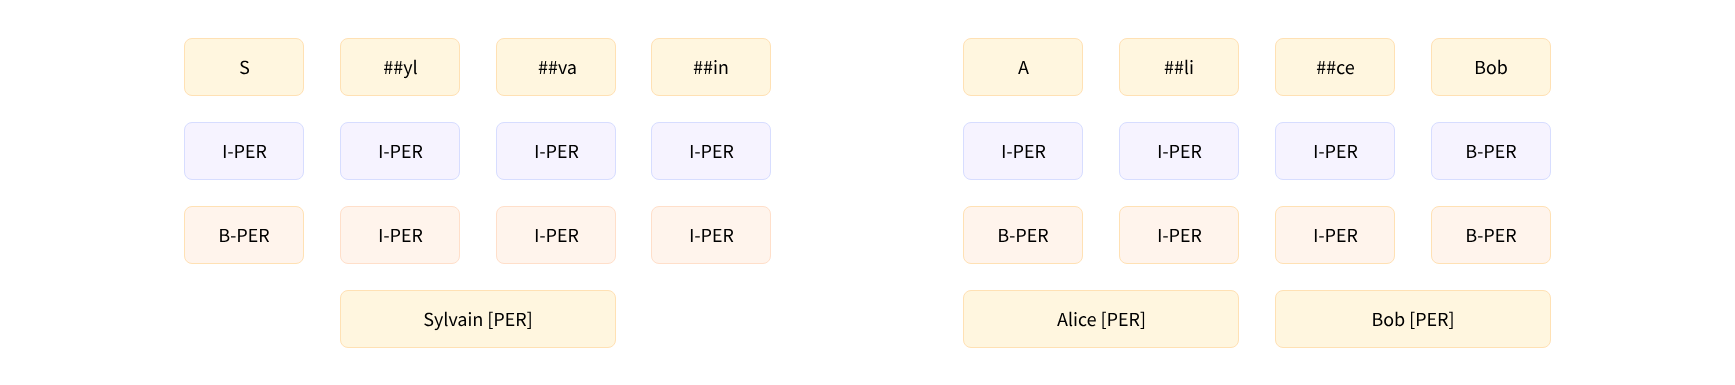

**Grouping entities**

Using the offsets to determine the start and end keys for each entity is handy, but that information isn’t strictly necessary, however, the offsets will save us a lot of messy code.

For example, if we wanted to group together the tokens Hu, ##gging, and Face, we could make special rules that say the first two should be attached while removing the ##, and the Face should be added with a space since it does not begin with ## — but that would only work for this particular type of tokenizer (Sentence Pience or BPE ).

With the offsets, all that custom code goes away: we just can take the span in the original text that begins with the first token and ends with the last token.

*We can write custom code to group entities* - https://huggingface.co/learn/nlp-course/chapter6/3?fw=pt

In [ ]:
example[33:45]

'Hugging Face'

# Fast Tokenizer with Q/A pipeline.

We'll see how to use off-set mapping in *Question answering*, by grabing the answer to the question at hand from the context, a bit like we did for the grouped entities in the previous section. *Unlike last pielines with small context, this pipeline one can handle very long contexts and tokens.*

The models in this pipelines are trained to predict the index of the tokens strating the answer and the index of the token of the ending of the answer.

In [ ]:
from transformers import pipeline
question_answerer = pipeline("question-answering")

question = "Which deep learning libraries back 🤗 Transformers?"

context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=context)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.9814445376396179,
 'start': 406,
 'end': 433,
 'answer': 'Jax, PyTorch and TensorFlow'}

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")
outputs = model(**inputs)

start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

torch.Size([1, 130]) torch.Size([1, 130])


Models for question answering work a little differently from the models we’ve seen up to now. The model has been trained to predict the index of the token starting the answer (here 21) and the index of the token where the answer ends (here 24). This is why those models don’t return one tensor of logits but two: one for the start token of the answer, and one for the end token of the answer.

Now converting these logits into probabilities , before that we need to mask some indecies that are not part of the context.

Our input is `[CLS] question [SEP] context [SEP]`. So we need to mask the tokens of the question as well as the [SEP] token. Since we will apply a softmax afterward, we just need to replace the logits we want to mask with a large negative number. Here, we use -10000:



In [ ]:
import torch

sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
mask = torch.tensor(mask)[None]

start_logits[mask] = -10000
end_logits[mask] = -10000

start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)[0]
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)[0]

# “The answer starts at start_index” and “The answer ends at end_index”

At this stage, we could take the argmax of the start and end probabilities. We could just take the start and end probabilities but there is a catch, we might end up with **start_index** that is bigger than **end_index** (if start is bigger then we're traveling in reverse index). So we will compute probabilities of each possible `start_index` and `end_index` where `start_index <= end_index` then take the tuple `(start_index, end_index)` with the highest probability.

Then we’ll mask the values where `start_index > end_index` by setting them to 0



In [ ]:
# First let’s compute all the possible products:
scores = start_probabilities[:, None] * end_probabilities[None, :]
# Then we’ll mask the values where start_index > end_index by setting them to 0
scores = torch.triu(scores)
#The torch.triu() function returns the upper triangular part of the 2D tensor

max_index = scores.argmax().item()
start_index = max_index // scores.shape[1]
end_index = max_index % scores.shape[1]
# use the floor division // and modulus % operations to get the start_index and end_index:
print("Start index :", start_index)
print("End index :", end_index)
print(scores[start_index, end_index])

Start index : 87
End index : 98
tensor(0.9814, grad_fn=<SelectBackward0>)


We have the start_index and end_index of the answer in terms of tokens, so now we just need to convert to the character indices in the context. This is where the offsets will be super useful. We can grab them and use them like we did in the token classification task:

In [ ]:
inputs_with_offsets = tokenizer(question, context, return_offsets_mapping=True)
offsets = inputs_with_offsets["offset_mapping"]

start_char, _ = offsets[start_index]
_, end_char = offsets[end_index]
answer = context[start_char:end_char]

print(answer)

result = {
    "answer": answer,
    "start": start_char,
    "end": end_char,
    "score": scores[start_index, end_index]}

print(result)

inputs = tokenizer(question, context)
print(len(inputs["input_ids"]))

Jax, PyTorch and TensorFlow
{'answer': 'Jax, PyTorch and TensorFlow', 'start': 406, 'end': 433, 'score': tensor(0.9814, grad_fn=<SelectBackward0>)}
130


**Handling long contexts**

If we tokenize our inputs to maximum length then there is a very high risk of losing context, our answer might be at the end of the context too.

TO fix this the question answer pipeline offer us 2 strategy:

- One is to use the `only_second` truncation. Although this is not the solution.

```inputs = tokenizer(question, long_context, max_length=384, truncation="only_second")```

- The solution is to split the context into smaller chunks specifying the maximum length. To make sure we don’t split the context at exactly the wrong place to make it possible to find the answer.

In [ ]:
sentence = "This sentence is not too long but we are going to split it anyway. But it is fineee"
inputs = tokenizer(sentence, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] This sentence is not [SEP]
[CLS] is not too long [SEP]
[CLS] too long but we [SEP]
[CLS] but we are going [SEP]
[CLS] are going to split [SEP]
[CLS] to split it anyway [SEP]
[CLS] it anyway. But [SEP]
[CLS]. But it is [SEP]
[CLS] it is fineee [SEP]


In [ ]:
print(inputs.keys())
#The last key, overflow_to_sample_mapping, is a map that tells us which sentence each of the results corresponds to
print(inputs["overflow_to_sample_mapping"])

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])
[0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
sentences = [
    "This sentence is not too long but we are going to split it anyway.",
    "This sentence is shorter but will still get split.",]
inputs = tokenizer(
    sentences, truncation=True, return_overflowing_tokens=True, max_length=6, stride=2)

print(inputs["overflow_to_sample_mapping"])

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In the case of long context, the pipeline for `question-answering` usually holds a `max_length` of 384 and `stride` 128 by default as it has been pre-trained like that although we can set it. Thus we'll use those params and also padding too.

- These inputs  will contain the input IDs and attention masks the model expects, as well as the offsets and the `overflow_to_sample_mapping`. Since the model does not need these we'll pop them out.


In [ ]:
long_context = """
🤗 Transformers: State of the Art NLP

🤗 Transformers provides thousands of pretrained models to perform tasks on texts such as classification, information extraction,
question answering, summarization, translation, text generation and more in over 100 languages.
Its aim is to make cutting-edge NLP easier to use for everyone.

🤗 Transformers provides APIs to quickly download and use those pretrained models on a given text, fine-tune them on your own datasets and
then share them with the community on our model hub. At the same time, each python module defining an architecture is fully standalone and
can be modified to enable quick research experiments.

Why should I use transformers?

1. Easy-to-use state-of-the-art models:
  - High performance on NLU and NLG tasks.
  - Low barrier to entry for educators and practitioners.
  - Few user-facing abstractions with just three classes to learn.
  - A unified API for using all our pretrained models.
  - Lower compute costs, smaller carbon footprint:

2. Researchers can share trained models instead of always retraining.
  - Practitioners can reduce compute time and production costs.
  - Dozens of architectures with over 10,000 pretrained models, some in more than 100 languages.

3. Choose the right framework for every part of a model's lifetime:
  - Train state-of-the-art models in 3 lines of code.
  - Move a single model between TF2.0/PyTorch frameworks at will.
  - Seamlessly pick the right framework for training, evaluation and production.

4. Easily customize a model or an example to your needs:
  - We provide examples for each architecture to reproduce the results published by its original authors.
  - Model internals are exposed as consistently as possible.
  - Model files can be used independently of the library for quick experiments.

🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question_answerer(question=question, context=long_context)

{'score': 0.9714871048927307,
 'start': 1892,
 'end': 1919,
 'answer': 'Jax, PyTorch and TensorFlow'}

In [ ]:
inputs = tokenizer(
    question,
    long_context,
    stride=128,
    max_length=384,
    padding="longest",
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,)

# popping out the things the model does not need.
_ = inputs.pop("overflow_to_sample_mapping")
offsets = inputs.pop("offset_mapping")

inputs = inputs.convert_to_tensors("pt")
print(inputs["input_ids"].shape)

outputs = model(**inputs)
start_logits = outputs.start_logits
end_logits = outputs.end_logits
print(start_logits.shape, end_logits.shape)

# Like before, we first mask the tokens that are not part of the context before taking the softmax.
sequence_ids = inputs.sequence_ids()
# Mask everything apart from the tokens of the context
mask = [i != 1 for i in sequence_ids]
# Unmask the [CLS] token
mask[0] = False
# Mask all the [PAD] tokens
mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

start_logits[mask] = -10000
end_logits[mask] = -10000

#Then we can use the softmax to convert our logits to probabilities:
start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)

candidates = []
for start_probs, end_probs in zip(start_probabilities, end_probabilities):
    scores = start_probs[:, None] * end_probs[None, :]
    idx = torch.triu(scores).argmax().item()

    start_idx = idx // scores.shape[1]
    end_idx = idx % scores.shape[1]
    score = scores[start_idx, end_idx].item()
    candidates.append((start_idx, end_idx, score))

print(candidates)

torch.Size([2, 384])
torch.Size([2, 384]) torch.Size([2, 384])
[(0, 18, 0.33867067098617554), (173, 184, 0.9714868664741516)]


Those two candidates correspond to the best answers the model was able to find in each chunk. The model is way more confident the right answer is in the second part (which is a good sign!).

# Normalization and Pre-Tokenization.

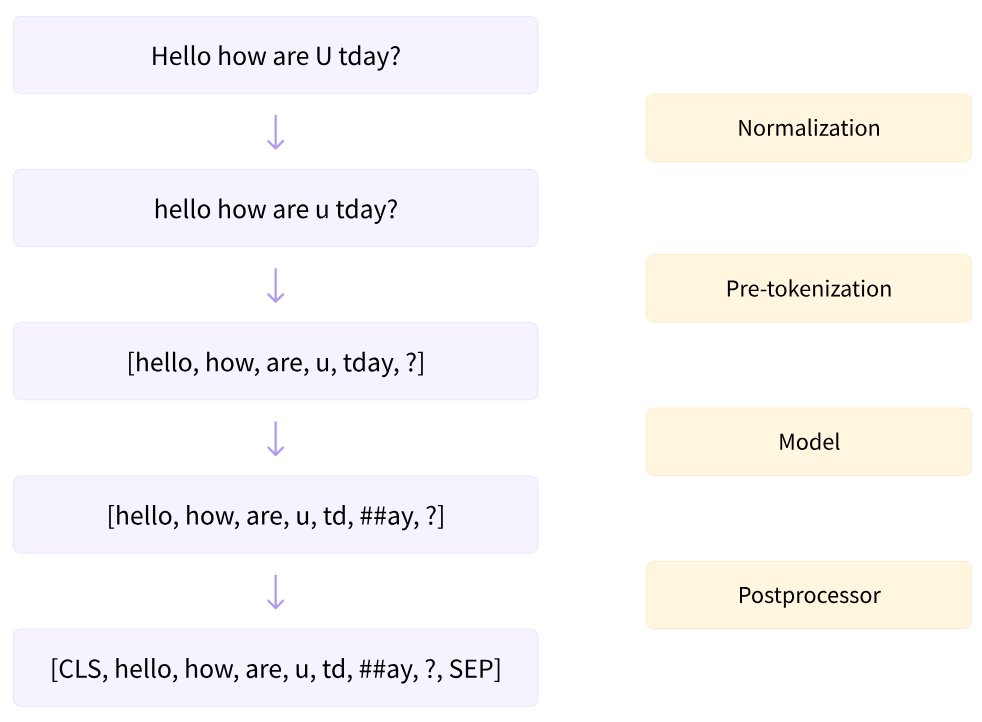

Normalization operation is done based on certain rules so that we remove noise that is not usefull for learning in the model. Some normalization can be very harmful if not adapted to the corpus properly!!!


The normalization step involves some general cleanup, such as removing needless whitespace, lowercasing, and/or removing accents.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print(type(tokenizer.backend_tokenizer))
print(tokenizer.backend_tokenizer.normalizer.normalize_str("Héllò hôw are ü? I havé a ballòòn"))

<class 'tokenizers.Tokenizer'>
hello how are u? i have a balloon


Tokenizers cannot be trained on raw texts instead it needs to be split into small entities first like words. Tokenizer can simply split a raw text into words on whitespace and punctuation.

In [ ]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('how', (7, 10)),
 ('are', (11, 14)),
 ('you', (16, 19)),
 ('?', (19, 20))]

Notice how the tokenizer is already keeping track of the offsets, which is how it can give us the offset mapping we used in the previous section. Here the tokenizer ignores the two spaces and replaces them with just one, but the offset jumps between are and you to account for that.

Since we’re using a BERT tokenizer, the pre-tokenization involves splitting on whitespace and punctuation. Other tokenizers can have different rules for this step. For example, if we use the GPT-2 tokenizer:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str("Hello, how are  you?")

[('Hello', (0, 5)),
 (',', (5, 6)),
 ('Ġhow', (6, 10)),
 ('Ġare', (10, 14)),
 ('Ġ', (14, 15)),
 ('Ġyou', (15, 19)),
 ('?', (19, 20))]

# Algorithms

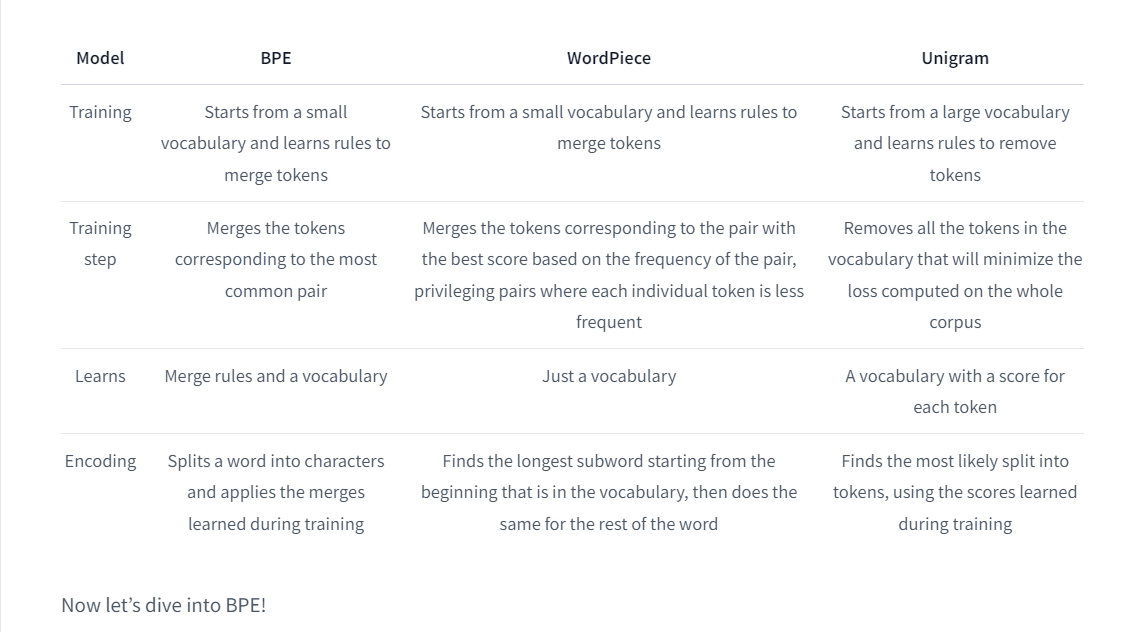

# Byte-Pair Encoding tokenization

The idea of BPE was proposed as a text compression algorithm at first. BPE starts with an initial vocabulary and then increase its size accordingly.

- BPE training starts by computing the unique set of words used in the corpus (after the normalization and pre-tokenization steps are completed) at the very least, and probably some Unicode characters as well.

- At any step during the tokenizer training, the BPE algorithm will search for the most frequent pair of existing tokens (by “pair,” here we mean two consecutive tokens in a word). That most frequent pair is the one that will be merged, and we rinse and repeat for the next step.

- In real world cases some tokenizers might replace stuff like emojis into `ukn` tokens that's why these models fail in NLP tasks.

- The GPT-2 and RoBERTa tokenizers (which are pretty similar) have a clever way to deal with this: they don’t look at words as being written with Unicode characters, but with bytes. This way the base vocabulary has a small size (256), but has every character you can think and not end up being converted to the unknown token. This trick is called **byte-level BPE.**

- After getting this base vocabulary, we add new tokens until the desired vocabulary size is reached by learning merges rules
-  which are rules to merge two elements of the existing vocabulary together into a new one. So, at the beginning these merges will create tokens with two characters, and then, as training progresses, longer subwords.

**Tokenization follows the training process closely**


1.   Normalization
2.   Pre-tokenization
3.   Splitting the words into individual characters
4.   Applying the merge rules learned in order on those splits


For example the word "bug" will be tokenized as ["b", "ug"]. "mug", however, will be tokenized as ["[UNK]", "ug"] since the letter "m" was not in the base vocabulary.


**Implementing BPE**

This implementation would not work in large corpus , this is just for understanding of the working concepts. First we'll take some sentence which will be treated as a corpus.

In [1]:
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]

Next, we need to pre-tokenize that corpus into words. Since we are replicating a BPE tokenizer (like GPT-2), we will use the gpt2 tokenizer for the pre-tokenization:

and also we compute the frequencies of each word in the corpus as we do the pre-tokenization:

In [3]:
from transformers import AutoTokenizer
from collections import defaultdict

tokenizer = AutoTokenizer.from_pretrained("gpt2")
word_freqs = defaultdict(int)

# we compute the frequencies of each word in the corpus as we do the pre-tokenization:
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

print(word_freqs)

defaultdict(<class 'int'>, {'This': 3, 'Ġis': 2, 'Ġthe': 1, 'ĠHugging': 1, 'ĠFace': 1, 'ĠCourse': 1, '.': 4, 'Ġchapter': 1, 'Ġabout': 1, 'Ġtokenization': 1, 'Ġsection': 1, 'Ġshows': 1, 'Ġseveral': 1, 'Ġtokenizer': 1, 'Ġalgorithms': 1, 'Hopefully': 1, ',': 1, 'Ġyou': 1, 'Ġwill': 1, 'Ġbe': 1, 'Ġable': 1, 'Ġto': 1, 'Ġunderstand': 1, 'Ġhow': 1, 'Ġthey': 1, 'Ġare': 1, 'Ġtrained': 1, 'Ġand': 1, 'Ġgenerate': 1, 'Ġtokens': 1})


- The next step is to compute the base vocabulary, formed by all the characters used in the corpus:

- We also add the special tokens used by the model at the beginning of that vocabulary. In the case of GPT-2, the only special token is "<|endoftext|>"

- We now need to split each word into individual characters, to be able to start training:

In [ ]:
# The next step is to compute the base vocabulary, formed by all the characters used in the corpus:
alphabet = []
for word in word_freqs.keys():
    for letter in word:
        if letter not in alphabet:
            alphabet.append(letter)
alphabet.sort()
print(alphabet)

vocab = ["<|endoftext|>"] + alphabet.copy()

splits = {word: [c for c in word] for word in word_freqs.keys()}

# finding the most frequent pais
best_pair = ""
max_freq = None

for pair, freq in pair_freqs.items():
    if max_freq is None or max_freq < freq:
        best_pair = pair
        max_freq = freq

print(best_pair, max_freq)

[',', '.', 'C', 'F', 'H', 'T', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z', 'Ġ']


As per the rules the first merge to learn is ('Ġ', 't') -> 'Ġt', and we add 'Ġt' to the vocabulary:

To continue, we need to apply that merge in our splits dictionary. Let’s write another function for this:




In [ ]:
merges = {("Ġ", "t"): "Ġt"}
vocab.append("Ġt")

def merge_pair(a, b, splits):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue

        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                split = split[:i] + [a + b] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

splits = merge_pair("Ġ", "t", splits)
print(splits["Ġtrained"])

['Ġt', 'r', 'a', 'i', 'n', 'e', 'd']


Now we have everything we need to loop until we have learned all the merges we want. Let’s aim for a vocab size of 50:



In [ ]:
vocab_size = 50

while len(vocab) < vocab_size:
    pair_freqs = compute_pair_freqs(splits)
    best_pair = ""
    max_freq = None
    for pair, freq in pair_freqs.items():
        if max_freq is None or max_freq < freq:
            best_pair = pair
            max_freq = freq
    splits = merge_pair(*best_pair, splits)
    merges[best_pair] = best_pair[0] + best_pair[1]
    vocab.append(best_pair[0] + best_pair[1])

print(merges)

{('Ġ', 't'): 'Ġt', ('i', 's'): 'is', ('e', 'r'): 'er', ('Ġ', 'a'): 'Ġa', ('Ġt', 'o'): 'Ġto', ('e', 'n'): 'en', ('T', 'h'): 'Th', ('Th', 'is'): 'This', ('o', 'u'): 'ou', ('s', 'e'): 'se', ('Ġto', 'k'): 'Ġtok', ('Ġtok', 'en'): 'Ġtoken', ('n', 'd'): 'nd', ('Ġ', 'is'): 'Ġis', ('Ġt', 'h'): 'Ġth', ('Ġth', 'e'): 'Ġthe', ('i', 'n'): 'in', ('Ġa', 'b'): 'Ġab'}


To tokenize a new text, we pre-tokenize it, split it, then apply all the merge rules learned:



In [ ]:
def tokenize(text):
    pre_tokenize_result = tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in pre_tokenize_result]
    splits = [[l for l in word] for word in pre_tokenized_text]
    for pair, merge in merges.items():
        for idx, split in enumerate(splits):
            i = 0
            while i < len(split) - 1:
                if split[i] == pair[0] and split[i + 1] == pair[1]:
                    split = split[:i] + [merge] + split[i + 2 :]
                else:
                    i += 1
            splits[idx] = split

    return sum(splits, [])

tokenize("This is not a token.")

['This', 'Ġis', 'Ġ', 'n', 'o', 't', 'Ġa', 'Ġtoken', '.']

# WordPiece tokenization Algorithm

- WordPiece is the tokenization algorithm Google developed to pretrain BERT. It has since been reused in quite a few Transformer models based on BERT, such as DistilBERT, MobileBERT. It’s very similar to BPE in terms of the training, but the actual tokenization is done differently.

- Like BPE WordPiece start with small vocabulary including the special tokens used by the model. Since it identifies words by adding a prefix (## for BERT) each word is initially split by adding that prefix:

Example: `word` is split into `w ##o ##r ##d`.

- Then, again like BPE, WordPiece learns merge rules. The main difference is the way the pair to be merged is selected. Instead of selecting the most frequent pair, WordPiece computes a score for each pair, using the following formula:

`score=(freq_of_pair)/(freq_of_first_element×freq_of_second_element)`

By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary.

For instance, it won’t necessarily merge ("un", "##able") even if that pair occurs very frequently in the vocabulary, because the two pairs "un" and "##able" will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like ("hu", "##gging") will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since "hu" and "##gging" are likely to be less frequent individually.

**Tokenization**

Lets look at the same example from BPE:

`("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)`

The splits will be:

`("h" "##u" "##g", 10), ("p" "##u" "##g", 5), ("p" "##u" "##n", 12), ("b" "##u" "##n", 4), ("h" "##u" "##g" "##s", 5)`

so the initial vocabulary will be ["b", "h", "p", "##g", "##n", "##s", "##u"]  The most frequent pair is ("##u", "##g") (present 20 times), but the individual frequency of "##u" is very high, so its score is not the highest (it’s 1 / 36). All pairs with a "##u" actually have that same score (1 / 36), so the best score goes to the pair ("##g", "##s") — the only one without a "##u" — at 1 / 20, and the first merge learned is ("##g", "##s") -> ("##gs").

*Note that when we merge, we remove the ## between the two tokens, so we add "##gs and we continue like this until we reach the desired vocabulary size.*

**Tokenization Algorithm**
Tokenization differs in WordPiece and BPE in that WordPiece only saves the final vocabulary, not the merge rules learned. Starting from the word to tokenize, WordPiece finds the longest subword that is in the vocabulary, then splits on it. For instance, if we use the vocabulary learned in the example above, for the word "hugs" the longest subword starting from the beginning that is inside the vocabulary is "hug", so we split there and get ["hug", "##s"]. We then continue with "##s", which is in the vocabulary, so the tokenization of "hugs" is ["hug", "##s"].

With BPE, we would have applied the merges learned in order and tokenized this as ["hu", "##gs"], so the encoding is different.

As another example, let’s see how the word "bugs" would be tokenized. "b" is the longest subword starting at the beginning of the word that is in the vocabulary, so we split there and get ["b", "##ugs"]. Then "##u" is the longest subword starting at the beginning of "##ugs" that is in the vocabulary, so we split there and get ["b", "##u, "##gs"]. Finally, "##gs" is in the vocabulary, so this last list is the tokenization of "bugs".


